In [8]:
#基础
import numpy as np
import pandas as pd
import time

#绘图
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#模型
from sklearn.linear_model import Lasso, LassoCV, ElasticNet, ElasticNetCV, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor#, StackingRegressor
from mlxtend.regressor import StackingRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.svm import SVR
import lightgbm as lgb
import xgboost as xgb

#模型相关
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

#忽略警告
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [9]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
print('The shape of training data:', train.shape)
print('The shape of testing data:', test.shape)

The shape of training data: (1458, 160)
The shape of testing data: (1459, 159)


Skewness of target: 1.8812964895244009
kurtosis of target: 6.523066888485879


<AxesSubplot:xlabel='SalePrice'>

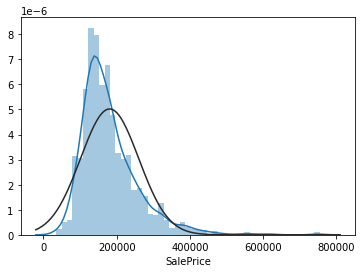

In [10]:
#查看目标值的斜度和峰度
from scipy.stats import skew, kurtosis, norm

y = train['SalePrice']
print('Skewness of target:', y.skew())
print('kurtosis of target:', y.kurtosis())
sns.distplot(y, fit=norm)

Skewness of target: 0.12157976050304882
kurtosis of target: 0.8047507917418972


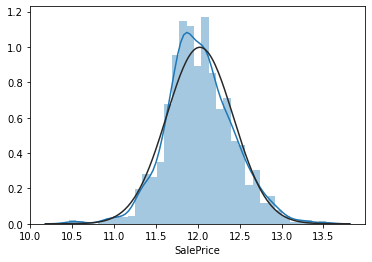

In [11]:
# 明显右偏，取对数
y = np.log1p(y)
print('Skewness of target:', y.skew())
print('kurtosis of target:', y.kurtosis())
sns.distplot(y, fit=norm);

# 定义交叉验证策略及评估方法
模型的验证有两种方法：留出法和交叉验证。因为训练集的数据较少，所以采用十折交叉验证：

In [12]:
#采用十折交叉验证
n_folds = 10

def rmse_cv(model):
    kf = KFold(n_folds, shuffle = True, random_state = 20)
    rmse = np.sqrt(-cross_val_score(model, train.values, y, scoring='neg_mean_squared_error', cv=kf))
    return(rmse)
# 用kf去分割数据集，返回值中是数据集的索引
# n_splits：k折交叉验证
# shuffle：是否每次生成数据集时进行洗牌
# random_state：仅当洗牌时有用，random_state数值相同时，生成的数据集一致。

# sklearn.model_selection.cross_val_score(estimator, X, y=None, groups=None, scoring=None, cv=’warn’, n_jobs=None, verbose=0, fit_params=None, pre_dispatch=‘2*n_jobs’, error_score=’raise-deprecating’)
# 参数：

# estimator： 需要使用交叉验证的算法
# X： 输入样本数据
# y： 样本标签
# groups： 将数据集分割为训练/测试集时使用的样本的组标签（一般用不到）
# scoring： 交叉验证最重要的就是他的验证方式，选择不同的评价方法，会产生不同的评价结果。具体可用哪些评价指标，官方已给出详细解释
# cv： 交叉验证折数或可迭代的次数
# n_jobs： 同时工作的cpu个数（-1代表全部）
# verbose： 详细程度
# fit_params： 传递给估计器（验证算法）的拟合方法的参数
# pre_dispatch： 控制并行执行期间调度的作业数量。减少这个数量对于避免在CPU发送更多作业时

# 单个模型参数设置
这里选择回归问题常用的六个模型：
· Lasso
· ElasticNet
· Ridge
· Gradient Boosting
· LightGBM
· XGBoost
kaggle的比赛中单个模型能做好，那么模型融合后的效果就不会差，因此，要反复地调参，找到模型的最佳参数。以下给出的参数设置是已经经过调参得到的，关于调参网上有很多经验分享，这里不另行赘述。

In [13]:
#Lasso
lasso_alpha = [0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
lasso = make_pipeline(RobustScaler(), LassoCV(alphas=lasso_alpha, random_state=2))

#ElasticNet
enet_beta = [0.1, 0.2, 0.5, 0.6, 0.8, 0.9]
enet_alpha = [0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01]
ENet = make_pipeline(RobustScaler(), ElasticNetCV(l1_ratio=enet_beta, alphas=enet_alpha, random_state=12))

#Ridge
rid_alpha = [0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
rid = make_pipeline(RobustScaler(), RidgeCV(alphas=rid_alpha))

#Gradient Boosting
gbr_params = {'loss': 'huber',
      'criterion': 'mse', 
      'learning_rate': 0.1,
      'n_estimators': 600, 
      'max_depth': 4,
      'subsample': 0.6,
      'min_samples_split': 20,
      'min_samples_leaf': 5,
      'max_features': 0.6,
      'random_state': 32,
      'alpha': 0.5}
gbr = GradientBoostingRegressor(**gbr_params)

#LightGBM
lgbr_params = {'learning_rate': 0.01,
      'n_estimators': 1850, 
      'max_depth': 4,
      'num_leaves': 20,
      'subsample': 0.6,
      'colsample_bytree': 0.6,
      'min_child_weight': 0.001,
      'min_child_samples': 21,
      'random_state': 42,
      'reg_alpha': 0,
      'reg_lambda': 0.05}
lgbr = lgb.LGBMRegressor(**lgbr_params)

#XGBoost
xgbr_params = {'learning_rate': 0.01,
      'n_estimators': 3000, 
      'max_depth': 5,
      'subsample': 0.6,
      'colsample_bytree': 0.7,
      'min_child_weight': 3,
      'seed': 52,
      'gamma': 0,
      'reg_alpha': 0,
      'reg_lambda': 1}
xgbr = xgb.XGBRegressor(**xgbr_params)

# 单个模型评估

In [14]:
models_name = ['Lasso', 'ElasticNet', 'Ridge', 'Gradient Boosting', 'LightGBM', 'XGBoost']
models = [lasso, ENet, rid, gbr, lgbr, xgbr]
for i, model in enumerate(models):
  score = rmse_cv(model)
  print('{} score: {}({})'.format(models_name[i], score.mean(), score.std()))


Lasso score: 0.07965985942594214(0.006335861414252078)
ElasticNet score: 0.07993986944209615(0.006102019530350986)
Ridge score: 0.07947770300812418(0.0063977565186917485)
Gradient Boosting score: 0.029990320218373778(0.007971904479482698)
LightGBM score: 0.048437248548040025(0.010511881096021095)
XGBoost score: 0.01544472365701767(0.003257071702381419)


# Stacking
模型融合有Stacking和Blending两种方法，可以直接采用mlxtend库提供的StackingCVRegressor构建Stacking模型：

In [15]:
stack_model = StackingCVRegressor(regressors=(lasso, ENet, rid, gbr, lgbr, xgbr), meta_regressor=lasso, use_features_in_secondary=True)

In [16]:
#Lasso
lasso_trained = lasso.fit(np.array(train), np.array(y))

#ElasticNet
ENet_trained = ENet.fit(np.array(train), np.array(y))

#Ridge
rid_trained = rid.fit(np.array(train), np.array(y))

#Gradient Boosting
gbr_trained = gbr.fit(np.array(train), np.array(y))

#LightGBM
lgbr_trained = lgbr.fit(np.array(train), np.array(y))

#XGBoost
xgbr_trained = xgbr.fit(np.array(train), np.array(y))

#Stacking
stack_model_trained = stack_model.fit(np.array(train), np.array(y))

# 评估各个模型在训练集上的表现

In [17]:
def rmse(y, y_preds):
  return np.sqrt(mean_squared_error(y, y_preds))

In [18]:
models.append(stack_model)
models_name.append('Stacking_model')
for i, model in enumerate(models):
  y_preds = model.predict(np.array(train))
  model_score = rmse(y, y_preds)
  print('RMSE of {}: {}'.format(models_name[i], model_score))

RMSE of Lasso: 0.06761594266461836
RMSE of ElasticNet: 0.06806914121506645
RMSE of Ridge: 0.066869468492126
RMSE of Gradient Boosting: 0.011726972537781087
RMSE of LightGBM: 0.02192183891792597
RMSE of XGBoost: 0.002065563798753672
RMSE of Stacking_model: 0.00942587742658555


In [19]:
# 提交预测结果
sample_submission = pd.read_csv('sample_submission.csv')
for i, model in enumerate(models):
  preds = model.predict(np.array(test))
  submission = pd.DataFrame({'Id': sample_submission['Id'], 'SalePrice': np.expm1(preds)})
  submission.to_csv('House_Price_submission_'+models_name[i]+'_optimation.csv', index=False)
  print('{} finished.'.format(models_name[i]))

ValueError: operands could not be broadcast together with shapes (1459,159) (160,) (1459,159) 

# Blending
采用两种比较简单的融合方法：均值融合和加权融合。

In [ ]:
#均值融合
preds_in_train = np.zeros((len(y), len(models)))
for i, model in enumerate(models):
  preds_in_train[:, i] = model.predict(np.array(train))
average_preds_in_train = preds_in_train.mean(axis=1)
average_score = rmse(y, average_preds_in_train)
print('RMSE of average model on training data:', average_score)

In [ ]:
#提交均值融合预测结果
preds_in_test = np.zeros((len(test), len(models)))
for i, model in enumerate(models):
  preds_in_test[:, i] = model.predict(np.array(test))
average_preds_in_test = preds_in_test.mean(axis=1)

average_submission = pd.DataFrame({'Id': sample_submission['Id'], 'SalePrice': np.expm1(average_preds_in_test)})
average_submission.to_csv('House_Price_submission_average_model_optimation.csv', index=False)

In [ ]:
# 加权融合
model_weights = [0.15, 0.12, 0.08, 0.08, 0.12, 0.15, 0.3]
weight_preds_in_train = np.matmul(preds_in_train, model_weights)

weight_score = rmse(y, weight_preds_in_train)
print('RMSE of weight model on training data:', weight_score)

In [ ]:
#提交权值融合预测结果
weight_preds_in_test = np.matmul(preds_in_test, model_weights)

weight_submission = pd.DataFrame({'Id': sample_submission['Id'], 'SalePrice': np.expm1(weight_preds_in_test)})
weight_submission.to_csv('House_Price_submission_weight_model_optimation.csv', index=False)